In [45]:
import os
import pandas as pd
import numpy as np
import re
import ast
import json
DATA_DIR = '../../data/Evaluation_CoTs/'
storage_dir = os.path.join(DATA_DIR, 'Algo_Design_Data')
file_store_path = os.path.join(storage_dir, 'final_extracted.json')
import sys
sys.path.insert(0, '../')
from utils import *

# to do: if we will use supervised learning model, need to run other experiments like other Supervised learning model

In [46]:
from CS_based_early_stopping import trained_LR_model, CS_early_stopping,trained_RF_model,trained_NB_model
import itertools
from itertools import combinations


feature_li = ['LEN','QUA_IM','DIF_IV','SIM_INPUT','SIM_COT_BIGRAM','SIM_COT_AGG','SIM_AC_BIGRAM','SIM_AC_PW']

df = pd.read_json(file_store_path, lines=True)
df = df[df.Model != 'gpt-4'].reset_index(drop=True)

In [47]:
df['SC_correctness'].mean()

0.43395805443998214

In [48]:
# df = pd.read_json(os.path.join(storage_dir, 'final_extracted_ES.json'), lines=True)
# df = df[df.Model != 'gpt-4'].reset_index(drop=True)

# Abalation Study 2: Compare effects of different IDV score models

In [49]:
df['direct_acc'] = df['Correctness'].apply(lambda x: x[0])

# Calculate the mean of 'direct_acc' and assign it to a new variable 'direct_acc_mean'
direct_acc_mean = df['direct_acc'].mean()

def abs_metric1(acc, cost, sc_acc, sc_cost=40, direct_acc=direct_acc_mean, direct_cost=1):
    if direct_acc is None:
        direct_acc = sc_acc

    # Normalize the accuracy to be between 0 and 1
    if acc >= sc_acc:
        acc_factor = 1
    elif acc <= direct_acc:
        acc_factor = 0
    else:
        acc_factor = (acc - direct_acc) / (sc_acc - direct_acc)

    # Normalize the cost to be between 0 and 1
    if cost <= direct_cost:
        cost_factor = 1
    elif cost >= sc_cost:
        cost_factor = 0
    else:
        cost_factor = (sc_cost - cost) / (sc_cost - direct_cost)

    # Calculate the weighted average of acc_factor and cost_factor
    metric = 0.5 * acc_factor + 0.5 * cost_factor

    return metric

### LR

In [50]:
feature_li = ['LEN','QUA_IM','DIF_IV','SIM_INPUT','SIM_COT_BIGRAM','SIM_COT_AGG','SIM_AC_BIGRAM','SIM_AC_PW']
df_cs_lr,auroc = trained_LR_model(df, feature_li)

Train DataFrame:
Model
llama3_cleaned             2099
claude-3-haiku-20240307    2097
gpt-3.5-turbo-0125         2078
Name: count, dtype: int64
Name
GSM8K_test               1050
GSM8K_hard               1050
MathQA_challenge_test    1047
BigBench_hard            1047
MathQA_dev               1041
BigBench_easy            1039
Name: count, dtype: int64

Test DataFrame:
Model
claude-3-haiku-20240307    900
llama3_cleaned             900
gpt-3.5-turbo-0125         890
Name: count, dtype: int64
Name
BigBench_hard            450
GSM8K_hard               450
GSM8K_test               450
MathQA_challenge_test    448
MathQA_dev               447
BigBench_easy            445
Name: count, dtype: int64
         Current function value: 0.506344
         Iterations: 35


/Users/guangyawan/miniconda3/envs/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            Correctness   No. Observations:               250960
Model:                          Logit   Df Residuals:                   250951
Method:                           MLE   Df Model:                            8
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:                  0.2456
Time:                        14:09:22   Log-Likelihood:            -1.2707e+05
converged:                      False   LL-Null:                   -1.6844e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.6921      0.023   -118.037      0.000      -2.737      -2.647
LEN               -0.1062      0.010    -10.938      0.000      -0.125      -0.087
QUA_IM            -1.2285      0.067

In [66]:

df_cs_lr,auroc = trained_LR_model(df, feature_li, report_auroc=True, random_state=2023)
def find_best_parameters(df, abs_metric_func, N_range=(3, 10), threshold_range=(0.1, 0.5), step=0.1):
    best_metric = float('-inf')
    best_threshold = None
    best_N = None
    best_df_final = None
    best_acc = None
    best_cost = None

    for N in range(N_range[0], N_range[1] + 1):
        for threshold in np.arange(threshold_range[0], threshold_range[1] + step, step):
            df_final = CS_early_stopping(df=df, threshold=threshold, N=N)
            acc = df_final['CS_correctness'].mean()
            cost = df_final['CS_steps'].mean()
            sc_acc = df_final['SC_correctness'].mean()
            metric = abs_metric_func(acc, cost, sc_acc)

            if metric > best_metric:
                best_metric = metric
                best_threshold = threshold
                best_N = N
                best_df_final = df_final.copy()
            
                best_acc = acc
                best_cost = cost

    print(f"Best parameters: N={best_N}, threshold={best_threshold}, metric={best_metric}, accuracy={best_acc}, cost={best_cost}")
    return best_df_final

Train DataFrame:
Model
llama3_cleaned             2099
claude-3-haiku-20240307    2097
gpt-3.5-turbo-0125         2078
Name: count, dtype: int64
Name
GSM8K_test               1050
GSM8K_hard               1050
MathQA_challenge_test    1047
BigBench_hard            1047
MathQA_dev               1041
BigBench_easy            1039
Name: count, dtype: int64

Test DataFrame:
Model
llama3_cleaned             900
claude-3-haiku-20240307    900
gpt-3.5-turbo-0125         890
Name: count, dtype: int64
Name
GSM8K_hard               450
GSM8K_test               450
BigBench_hard            450
MathQA_challenge_test    448
MathQA_dev               447
BigBench_easy            445
Name: count, dtype: int64
         Current function value: 0.507945
         Iterations: 35


/Users/guangyawan/miniconda3/envs/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            Correctness   No. Observations:               250960
Model:                          Logit   Df Residuals:                   250951
Method:                           MLE   Df Model:                            8
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:                  0.2436
Time:                        15:36:49   Log-Likelihood:            -1.2747e+05
converged:                      False   LL-Null:                   -1.6852e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.6052      0.023   -114.902      0.000      -2.650      -2.561
LEN               -0.0639      0.010     -6.588      0.000      -0.083      -0.045
QUA_IM            -1.1469      0.064

In [67]:
import pandas as pd

random_states = [2023, 42, 1234, 5678, 9012, 3456, 7890, 1111, 2222, 3333]
results = []
results_dfs = []
for random_state in random_states:
    df_cs_lr, auroc = trained_LR_model(df, feature_li, report_auroc=True, random_state=random_state)
    df_final_best = find_best_parameters(df_cs_lr, abs_metric1)
    results_dfs.append(df_final_best)
    acc = df_final_best['CS_correctness'].mean()
    cost = df_final_best['CS_steps'].mean()
    
    results.append({'Random State': random_state, 'Accuracy': acc, 'Cost': cost})

results_df = pd.DataFrame(results)
print("Results for different random states:")
print(results_df)

print("\nSummary statistics:")
print(f"Accuracy - Mean: {results_df['Accuracy'].mean():.4f}, Std: {results_df['Accuracy'].std():.4f}, Max: {results_df['Accuracy'].max():.4f}, Min: {results_df['Accuracy'].min():.4f}")
print(f"Cost - Mean: {results_df['Cost'].mean():.4f}, Std: {results_df['Cost'].std():.4f}, Max: {results_df['Cost'].max():.4f}, Min: {results_df['Cost'].min():.4f}")

Train DataFrame:
Model
llama3_cleaned             2099
claude-3-haiku-20240307    2097
gpt-3.5-turbo-0125         2078
Name: count, dtype: int64
Name
GSM8K_test               1050
GSM8K_hard               1050
MathQA_challenge_test    1047
BigBench_hard            1047
MathQA_dev               1041
BigBench_easy            1039
Name: count, dtype: int64

Test DataFrame:
Model
llama3_cleaned             900
claude-3-haiku-20240307    900
gpt-3.5-turbo-0125         890
Name: count, dtype: int64
Name
GSM8K_hard               450
GSM8K_test               450
BigBench_hard            450
MathQA_challenge_test    448
MathQA_dev               447
BigBench_easy            445
Name: count, dtype: int64
         Current function value: 0.507945
         Iterations: 35


/Users/guangyawan/miniconda3/envs/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            Correctness   No. Observations:               250960
Model:                          Logit   Df Residuals:                   250951
Method:                           MLE   Df Model:                            8
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:                  0.2436
Time:                        15:37:02   Log-Likelihood:            -1.2747e+05
converged:                      False   LL-Null:                   -1.6852e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.6052      0.023   -114.902      0.000      -2.650      -2.561
LEN               -0.0639      0.010     -6.588      0.000      -0.083      -0.045
QUA_IM            -1.1469      0.064

/Users/guangyawan/miniconda3/envs/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            Correctness   No. Observations:               250960
Model:                          Logit   Df Residuals:                   250951
Method:                           MLE   Df Model:                            8
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:                  0.2466
Time:                        15:37:09   Log-Likelihood:            -1.2691e+05
converged:                      False   LL-Null:                   -1.6844e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.6936      0.023   -117.877      0.000      -2.738      -2.649
LEN               -0.0727      0.010     -7.469      0.000      -0.092      -0.054
QUA_IM            -1.0956      0.063

/Users/guangyawan/miniconda3/envs/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            Correctness   No. Observations:               250960
Model:                          Logit   Df Residuals:                   250951
Method:                           MLE   Df Model:                            8
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:                  0.2405
Time:                        15:37:16   Log-Likelihood:            -1.2784e+05
converged:                      False   LL-Null:                   -1.6832e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.6607      0.023   -117.181      0.000      -2.705      -2.616
LEN               -0.0844      0.010     -8.722      0.000      -0.103      -0.065
QUA_IM            -1.1728      0.064

/Users/guangyawan/miniconda3/envs/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            Correctness   No. Observations:               250960
Model:                          Logit   Df Residuals:                   250951
Method:                           MLE   Df Model:                            8
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:                  0.2429
Time:                        15:37:22   Log-Likelihood:            -1.2742e+05
converged:                      False   LL-Null:                   -1.6831e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.6540      0.023   -116.440      0.000      -2.699      -2.609
LEN               -0.0634      0.010     -6.536      0.000      -0.082      -0.044
QUA_IM            -1.0600      0.061

/Users/guangyawan/miniconda3/envs/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            Correctness   No. Observations:               250960
Model:                          Logit   Df Residuals:                   250951
Method:                           MLE   Df Model:                            8
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:                  0.2429
Time:                        15:37:29   Log-Likelihood:            -1.2745e+05
converged:                      False   LL-Null:                   -1.6833e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.6220      0.023   -115.382      0.000      -2.667      -2.577
LEN               -0.1121      0.010    -11.564      0.000      -0.131      -0.093
QUA_IM            -1.0156      0.061

/Users/guangyawan/miniconda3/envs/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            Correctness   No. Observations:               250960
Model:                          Logit   Df Residuals:                   250951
Method:                           MLE   Df Model:                            8
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:                  0.2466
Time:                        15:37:35   Log-Likelihood:            -1.2653e+05
converged:                      False   LL-Null:                   -1.6795e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.7090      0.023   -118.216      0.000      -2.754      -2.664
LEN               -0.0664      0.010     -6.819      0.000      -0.085      -0.047
QUA_IM            -1.0984      0.067

/Users/guangyawan/miniconda3/envs/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            Correctness   No. Observations:               250960
Model:                          Logit   Df Residuals:                   250951
Method:                           MLE   Df Model:                            8
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:                  0.2387
Time:                        15:37:49   Log-Likelihood:            -1.2827e+05
converged:                      False   LL-Null:                   -1.6849e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.6281      0.023   -115.754      0.000      -2.673      -2.584
LEN               -0.0714      0.010     -7.393      0.000      -0.090      -0.052
QUA_IM            -1.1326      0.062

/Users/guangyawan/miniconda3/envs/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            Correctness   No. Observations:               250960
Model:                          Logit   Df Residuals:                   250951
Method:                           MLE   Df Model:                            8
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:                  0.2451
Time:                        15:37:57   Log-Likelihood:            -1.2691e+05
converged:                      False   LL-Null:                   -1.6811e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.6315      0.023   -115.394      0.000      -2.676      -2.587
LEN               -0.1007      0.010    -10.378      0.000      -0.120      -0.082
QUA_IM            -1.2106      0.067

/Users/guangyawan/miniconda3/envs/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            Correctness   No. Observations:               250960
Model:                          Logit   Df Residuals:                   250951
Method:                           MLE   Df Model:                            8
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:                  0.2456
Time:                        15:38:07   Log-Likelihood:            -1.2699e+05
converged:                      False   LL-Null:                   -1.6832e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.6363      0.023   -115.374      0.000      -2.681      -2.592
LEN               -0.0583      0.010     -5.994      0.000      -0.077      -0.039
QUA_IM            -1.0221      0.061

In [68]:
print("Results for different random states:")
print(results_df)

print("\nSummary statistics:")
print(f"Accuracy - Mean: {results_df['Accuracy'].mean():.4f}, Std: {results_df['Accuracy'].std():.4f}, Max: {results_df['Accuracy'].max():.4f}, Min: {results_df['Accuracy'].min():.4f}")
print(f"Cost - Mean: {results_df['Cost'].mean():.4f}, Std: {results_df['Cost'].std():.4f}, Max: {results_df['Cost'].max():.4f}, Min: {results_df['Cost'].min():.4f}")

Results for different random states:
   Random State  Accuracy      Cost
0          2023  0.449071  5.940892
1            42  0.460223  5.873606
2          1234  0.462082  6.218587
3          5678  0.458364  5.985874
4          9012  0.457621  6.147212
5          3456  0.458736  5.827881
6          7890  0.464312  5.817844
7          1111  0.447955  6.057993
8          2222  0.457249  5.749814
9          3333  0.457621  5.785130

Summary statistics:
Accuracy - Mean: 0.4573, Std: 0.0052, Max: 0.4643, Min: 0.4480
Cost - Mean: 5.9405, Std: 0.1594, Max: 6.2186, Min: 5.7498


In [75]:
import pandas as pd
from scipy import stats

# Create an empty list to store the summary statistics for each DataFrame
summary_stats_list = []

# Iterate over each DataFrame in results_dfs
for i, df in enumerate(results_dfs):
    # Group by 'Name' and 'Model' and calculate the mean, min, and max of 'CS_correctness'
    grouped_stats = df.groupby(['Name', 'Model'])['CS_correctness'].agg(['mean', 'min', 'max'])
    
    # Calculate the average of 'SC_correctness' for each group
    sc_avg = df.groupby(['Name', 'Model'])['SC_correctness'].mean()
    
    # Merge the grouped statistics with the average of 'SC_correctness'
    result = pd.merge(grouped_stats, sc_avg, on=['Name', 'Model'], suffixes=('_CS', '_SC'))
    
    # Calculate the difference between the mean of 'CS_correctness' and the average of 'SC_correctness'
    result['Difference'] = result['mean'] - result['SC_correctness']
    
    # Add the random state column to the result DataFrame
    result['Random State'] = random_states[i]
    
    # Append the result DataFrame to the summary_stats_list
    summary_stats_list.append(result)

# Concatenate all the summary statistics DataFrames into a single DataFrame
final_summary_stats = pd.concat(summary_stats_list)

# Apply the one-sample t-test to the 'Difference' to test if it's significantly greater than 0
final_summary_stats['p_value'] = final_summary_stats.groupby(['Name', 'Model'])['Difference'].transform(
    lambda x: stats.ttest_1samp(x, 0)[1]
)

# Calculate mean, standard deviation, and p-value for final report
summary_stats = final_summary_stats.groupby(['Name', 'Model']).agg({
    'mean': ['mean', 'std'],
    'SC_correctness': ['mean', 'std'],
    'Difference': ['mean', 'std'],
    'p_value': 'mean'  # Mean p-value across different seeds
})

# Print the summary statistics
print("Summary statistics for each group (Name and Model) across all random states, including p-values:")
print(summary_stats)

# Calculate the overall accuracy and cost metrics for each random state
overall_metrics = pd.DataFrame({
    'Random State': random_states,
    'Accuracy': [df['CS_correctness'].mean() for df in results_dfs],
    'Cost': [df['CS_steps'].mean() for df in results_dfs]
})

# Print the overall metrics for each random state
print("\nOverall metrics for each random state:")
print(overall_metrics)

# Calculate and print the mean and standard deviation of the overall accuracy and cost metrics
print("\nSummary statistics for overall metrics:")
print(f"Accuracy - Mean: {overall_metrics['Accuracy'].mean():.4f}, Std: {overall_metrics['Accuracy'].std():.4f}")
print(f"Cost - Mean: {overall_metrics['Cost'].mean():.4f}, Std: {overall_metrics['Cost'].std():.4f}")



Summary statistics for each group (Name and Model) across all random states, including p-values:
                                                   mean            \
                                                   mean       std   
Name                  Model                                         
BigBench_easy         claude-3-haiku-20240307  0.263333  0.029523   
                      gpt-3.5-turbo-0125       0.275862  0.023890   
                      llama3_cleaned           0.303333  0.032848   
BigBench_hard         claude-3-haiku-20240307  0.690000  0.032241   
                      gpt-3.5-turbo-0125       0.675333  0.036114   
                      llama3_cleaned           0.308667  0.028640   
GSM8K_hard            claude-3-haiku-20240307  0.395333  0.042866   
                      gpt-3.5-turbo-0125       0.465333  0.023264   
                      llama3_cleaned           0.247333  0.028363   
GSM8K_test            claude-3-haiku-20240307  0.800667  0.023612   
      

In [76]:
import pandas as pd
from scipy import stats

# Create an empty list to store the summary statistics for each DataFrame
summary_stats_list = []

# Iterate over each DataFrame in results_dfs
for i, df in enumerate(results_dfs):
    # Group by 'Name' and 'Model' and calculate the mean, min, and max of 'CS_steps'
    grouped_stats = df.groupby(['Name', 'Model'])['CS_steps'].agg(['mean', 'min', 'max'])
    
    # Add the random state column to the result DataFrame
    grouped_stats['Random State'] = random_states[i]
    
    # Append the result DataFrame to the summary_stats_list
    summary_stats_list.append(grouped_stats)

# Concatenate all the summary statistics DataFrames into a single DataFrame
final_summary_stats = pd.concat(summary_stats_list)

# Apply the one-sample t-test to the 'mean' to test if it's significantly smaller than 40
final_summary_stats['p_value'] = final_summary_stats.groupby(['Name', 'Model'])['mean'].transform(
    lambda x: stats.ttest_1samp(x, 40, alternative='less')[1]
)

# Calculate mean, standard deviation, and p-value for final report
summary_stats = final_summary_stats.groupby(['Name', 'Model']).agg({
    'mean': ['mean', 'std'],
    'p_value': 'mean'  # Mean p-value across different seeds
})

# Print the summary statistics
print("Summary statistics for CS_steps in each group (Name and Model) across all random states, including p-values:")
print(summary_stats)

# Calculate the overall accuracy and cost metrics for each random state
overall_metrics = pd.DataFrame({
    'Random State': random_states,
    'Accuracy': [df['CS_correctness'].mean() for df in results_dfs],
    'Cost': [df['CS_steps'].mean() for df in results_dfs]
})

# Print the overall metrics for each random state
print("\nOverall metrics for each random state:")
print(overall_metrics)

# Calculate and print the mean and standard deviation of the overall accuracy and cost metrics
print("\nSummary statistics for overall metrics:")
print(f"Accuracy - Mean: {overall_metrics['Accuracy'].mean():.4f}, Std: {overall_metrics['Accuracy'].std():.4f}")
print(f"Cost - Mean: {overall_metrics['Cost'].mean():.4f}, Std: {overall_metrics['Cost'].std():.4f}")

Summary statistics for CS_steps in each group (Name and Model) across all random states, including p-values:
                                                    mean            \
                                                    mean       std   
Name                  Model                                          
BigBench_easy         claude-3-haiku-20240307   3.004000  0.004661   
                      gpt-3.5-turbo-0125        4.559310  0.293488   
                      llama3_cleaned           11.569333  0.714735   
BigBench_hard         claude-3-haiku-20240307   3.018000  0.009963   
                      gpt-3.5-turbo-0125        4.750667  0.200941   
                      llama3_cleaned           12.094000  0.932219   
GSM8K_hard            claude-3-haiku-20240307   3.191333  0.131695   
                      gpt-3.5-turbo-0125        4.060667  0.352787   
                      llama3_cleaned            3.056000  0.033140   
GSM8K_test            claude-3-haiku-20240307   3.1

In [70]:
result 

mean  min  max  \
Name                  Model                                         
BigBench_easy         claude-3-haiku-20240307  0.240000    0    1   
                      gpt-3.5-turbo-0125       0.282759    0    1   
                      llama3_cleaned           0.306667    0    1   
BigBench_hard         claude-3-haiku-20240307  0.706667    0    1   
                      gpt-3.5-turbo-0125       0.646667    0    1   
                      llama3_cleaned           0.253333    0    1   
GSM8K_hard            claude-3-haiku-20240307  0.333333    0    1   
                      gpt-3.5-turbo-0125       0.493333    0    1   
                      llama3_cleaned           0.273333    0    1   
GSM8K_test            claude-3-haiku-20240307  0.773333    0    1   
                      gpt-3.5-turbo-0125       0.786667    0    1   
                      llama3_cleaned           0.720000    0    1   
MathQA_challenge_test claude-3-haiku-20240307  0.540000    0    1   
                      gpt-3.5-turbo-0125       0.500000    0    1   
                      llama3_cleaned           0.120000    0    1   
MathQA_dev            claude-3-haiku-20240307  0.520000    0    1   
                      gpt-3.5-turbo-0125       0.469388    0    1   
                      llama3_cleaned           0.113333    0    1   

                                               SC_correctness  
Name                  Model                                    
BigBench_easy         claude-3-haiku-20240307        0.253333  
                      gpt-3.5-turbo-0125             0.310345  
                      llama3_cleaned                 0.080000  
BigBench_hard         claude-3-haiku-20240307        0.693333  
                      gpt-3.5-turbo-0125             0.606667  
                      llama3_cleaned                 0.040000  
GSM8K_hard            claude-3-haiku-20240307        0.353333  
                      gpt-3.5-turbo-0125             0.493333  
                      llama3_cleaned                 0.280000  
GSM8K_test            claude-3-haiku-20240307        0.840000  
                      gpt-3.5-turbo-0125             0.820000  
                      llama3_cleaned                 0.746667  
MathQA_challenge_test claude-3-haiku-20240307        0.553333  
                      gpt-3.5-turbo-0125             0.432432  
                      llama3_cleaned                 0.060000  
MathQA_dev            claude-3-haiku-20240307        0.573333  
                      gpt-3.5-turbo-0125             0.435374  
                      llama3_cleaned                 0.100000

In [55]:
import pandas as pd

random_states = [2023, 42, 1234, 5678, 9012, 3456, 7890, 1111, 2222, 3333]
results = []

for random_state in random_states:
    df_cs_lr, auroc = trained_LR_model(df, feature_li, report_auroc=True, random_state=random_state)
    df_final_best = find_best_parameters(df_cs_lr, abs_metric1)
    
    acc = df_final_best['CS_correctness'].mean()
    cost = df_final_best['CS_steps'].mean()
    
    results.append({'Random State': random_state, 'Accuracy': acc, 'Cost': cost})

results_df = pd.DataFrame(results)
print("Results for different random states:")
print(results_df)

print("\nSummary statistics:")
print(f"Accuracy - Mean: {results_df['Accuracy'].mean():.4f}, Std: {results_df['Accuracy'].std():.4f}, Max: {results_df['Accuracy'].max():.4f}, Min: {results_df['Accuracy'].min():.4f}")
print(f"Cost - Mean: {results_df['Cost'].mean():.4f}, Std: {results_df['Cost'].std():.4f}, Max: {results_df['Cost'].max():.4f}, Min: {results_df['Cost'].min():.4f}")

Train DataFrame:
Model
llama3_cleaned             2099
claude-3-haiku-20240307    2097
gpt-3.5-turbo-0125         2078
Name: count, dtype: int64
Name
GSM8K_test               1050
GSM8K_hard               1050
MathQA_challenge_test    1047
BigBench_hard            1047
MathQA_dev               1041
BigBench_easy            1039
Name: count, dtype: int64

Test DataFrame:
Model
llama3_cleaned             900
claude-3-haiku-20240307    900
gpt-3.5-turbo-0125         890
Name: count, dtype: int64
Name
GSM8K_hard               450
GSM8K_test               450
BigBench_hard            450
MathQA_challenge_test    448
MathQA_dev               447
BigBench_easy            445
Name: count, dtype: int64
         Current function value: 0.507945
         Iterations: 35


/Users/guangyawan/miniconda3/envs/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            Correctness   No. Observations:               250960
Model:                          Logit   Df Residuals:                   250951
Method:                           MLE   Df Model:                            8
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:                  0.2436
Time:                        14:30:58   Log-Likelihood:            -1.2747e+05
converged:                      False   LL-Null:                   -1.6852e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.6052      0.023   -114.902      0.000      -2.650      -2.561
LEN               -0.0639      0.010     -6.588      0.000      -0.083      -0.045
QUA_IM            -1.1469      0.064

/Users/guangyawan/miniconda3/envs/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            Correctness   No. Observations:               250960
Model:                          Logit   Df Residuals:                   250951
Method:                           MLE   Df Model:                            8
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:                  0.2466
Time:                        14:31:05   Log-Likelihood:            -1.2691e+05
converged:                      False   LL-Null:                   -1.6844e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.6936      0.023   -117.877      0.000      -2.738      -2.649
LEN               -0.0727      0.010     -7.469      0.000      -0.092      -0.054
QUA_IM            -1.0956      0.063

/Users/guangyawan/miniconda3/envs/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            Correctness   No. Observations:               250960
Model:                          Logit   Df Residuals:                   250951
Method:                           MLE   Df Model:                            8
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:                  0.2405
Time:                        14:31:12   Log-Likelihood:            -1.2784e+05
converged:                      False   LL-Null:                   -1.6832e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.6607      0.023   -117.181      0.000      -2.705      -2.616
LEN               -0.0844      0.010     -8.722      0.000      -0.103      -0.065
QUA_IM            -1.1728      0.064

/Users/guangyawan/miniconda3/envs/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            Correctness   No. Observations:               250960
Model:                          Logit   Df Residuals:                   250951
Method:                           MLE   Df Model:                            8
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:                  0.2429
Time:                        14:31:19   Log-Likelihood:            -1.2742e+05
converged:                      False   LL-Null:                   -1.6831e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.6540      0.023   -116.440      0.000      -2.699      -2.609
LEN               -0.0634      0.010     -6.536      0.000      -0.082      -0.044
QUA_IM            -1.0600      0.061

/Users/guangyawan/miniconda3/envs/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            Correctness   No. Observations:               250960
Model:                          Logit   Df Residuals:                   250951
Method:                           MLE   Df Model:                            8
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:                  0.2429
Time:                        14:31:25   Log-Likelihood:            -1.2745e+05
converged:                      False   LL-Null:                   -1.6833e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.6220      0.023   -115.382      0.000      -2.667      -2.577
LEN               -0.1121      0.010    -11.564      0.000      -0.131      -0.093
QUA_IM            -1.0156      0.061

/Users/guangyawan/miniconda3/envs/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            Correctness   No. Observations:               250960
Model:                          Logit   Df Residuals:                   250951
Method:                           MLE   Df Model:                            8
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:                  0.2466
Time:                        14:31:32   Log-Likelihood:            -1.2653e+05
converged:                      False   LL-Null:                   -1.6795e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.7090      0.023   -118.216      0.000      -2.754      -2.664
LEN               -0.0664      0.010     -6.819      0.000      -0.085      -0.047
QUA_IM            -1.0984      0.067

/Users/guangyawan/miniconda3/envs/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            Correctness   No. Observations:               250960
Model:                          Logit   Df Residuals:                   250951
Method:                           MLE   Df Model:                            8
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:                  0.2387
Time:                        14:31:45   Log-Likelihood:            -1.2827e+05
converged:                      False   LL-Null:                   -1.6849e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.6281      0.023   -115.754      0.000      -2.673      -2.584
LEN               -0.0714      0.010     -7.393      0.000      -0.090      -0.052
QUA_IM            -1.1326      0.062

/Users/guangyawan/miniconda3/envs/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            Correctness   No. Observations:               250960
Model:                          Logit   Df Residuals:                   250951
Method:                           MLE   Df Model:                            8
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:                  0.2451
Time:                        14:31:52   Log-Likelihood:            -1.2691e+05
converged:                      False   LL-Null:                   -1.6811e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.6315      0.023   -115.394      0.000      -2.676      -2.587
LEN               -0.1007      0.010    -10.378      0.000      -0.120      -0.082
QUA_IM            -1.2106      0.067

/Users/guangyawan/miniconda3/envs/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            Correctness   No. Observations:               250960
Model:                          Logit   Df Residuals:                   250951
Method:                           MLE   Df Model:                            8
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:                  0.2456
Time:                        14:32:00   Log-Likelihood:            -1.2699e+05
converged:                      False   LL-Null:                   -1.6832e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.6363      0.023   -115.374      0.000      -2.681      -2.592
LEN               -0.0583      0.010     -5.994      0.000      -0.077      -0.039
QUA_IM            -1.0221      0.061

In [62]:
print("Results for different random states:")
print(results_df)

print("\nSummary statistics:")
print(f"Accuracy - Mean: {results_df['Accuracy'].mean():.4f}, Std: {results_df['Accuracy'].std():.4f}, Max: {results_df['Accuracy'].max():.4f}, Min: {results_df['Accuracy'].min():.4f}")
print(f"Cost - Mean: {results_df['Cost'].mean():.4f}, Std: {results_df['Cost'].std():.4f}, Max: {results_df['Cost'].max():.4f}, Min: {results_df['Cost'].min():.4f}")

Results for different random states:
   Random State  Accuracy       Cost
0          2023  0.454647  25.237918
1            42  0.456134  25.469888
2          1234  0.461710  25.875465
3          5678  0.466171  25.618216
4          9012  0.455019  25.537175
5          3456  0.460967  25.453160
6          7890  0.467286  25.747584
7          1111  0.461710  25.937918
8          2222  0.459108  25.820818
9          3333  0.452416  25.571375

Summary statistics:
Accuracy - Mean: 0.4595, Std: 0.0050, Max: 0.4673, Min: 0.4524
Cost - Mean: 25.6270, Std: 0.2181, Max: 25.9379, Min: 25.2379


In [57]:
results_df = pd.DataFrame(results)
print("Results for different random states:")
print(results_df)

print("\nSummary statistics:")
print(f"Accuracy - Mean: {results_df['Accuracy'].mean():.4f}, Std: {results_df['Accuracy'].std():.4f}, Max: {results_df['Accuracy'].max():.4f}, Min: {results_df['Accuracy'].min():.4f}")
print(f"Cost - Mean: {results_df['Cost'].mean():.4f}, Std: {results_df['Cost'].std():.4f}, Max: {results_df['Cost'].max():.4f}, Min: {results_df['Cost'].min():.4f}")

Results for different random states:
   Random State  Accuracy      Cost
0          2023  0.449071  5.940892
1            42  0.460223  5.873606
2          1234  0.462082  6.218587
3          5678  0.458364  5.985874
4          9012  0.457621  6.147212
5          3456  0.458736  5.827881
6          7890  0.464312  5.817844
7          1111  0.447955  6.057993
8          2222  0.457249  5.749814
9          3333  0.457621  5.785130

Summary statistics:
Accuracy - Mean: 0.4573, Std: 0.0052, Max: 0.4643, Min: 0.4480
Cost - Mean: 5.9405, Std: 0.1594, Max: 6.2186, Min: 5.7498


In [58]:
df_final_best

,id,Name,Model,correct answer,CoT answers,Correctness,SIM_COT_AGG,SIM_INPUT,QUA_IM,LEN,...,SC_correctness,ES_correctness,ES_steps,asc_correctness,asc_steps,direct_acc,confidence_score,CS_Answer,CS_correctness,CS_steps
0,7469,MathQA_dev,gpt-3.5-turbo-0125,b,"[b, d, b, b, error, b, e, b, b, b, error, b, e...","[1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, ...","[0.5, 0.4615384615, 0.4343434343, 0.2710280374...","[0.2747252747, 0.2948717949, 0.3142857143, 0.1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...",...,0,0,38,1,9,1,"[0.27694892361790807, 0.27868882293694425, 0.5...",b,1,40
1,5460,BigBench_easy,llama3_cleaned,B,"[A, error, error, error, error, B, error, B, e...","[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.5, 0.4051724138, 0.4296875, 0.397260274, 0....","[0.33766233770000004, 0.27619047620000003, 0.3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, ...",...,0,0,18,0,11,0,"[0.3032651218944041, 1.802182909182917e-11, 1....",C,0,40
2,5057,BigBench_hard,gpt-3.5-turbo-0125,B,"[B, B, B, B, B, error, B, B, B, B, B, B, B, B,...","[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.5, 0.4015748031, 0.40972222220000004, 0.406...","[0.18478260870000002, 0.1682242991, 0.18181818...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...",...,1,1,5,1,4,1,"[0.2527344515557392, 0.5670896182734438, 0.562...",B,1,13
3,9481,MathQA_challenge_test,llama3_cleaned,c,"[a, e, a, e, e, e, e, a, e, a, e, e, e, a, e, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.5, 0.3274853801, 0.3248730964, 0.3744680851...","[0.1805555556, 0.1885245902, 0.2407407407, 0.2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",...,0,0,25,0,21,0,"[0.24031716738075143, 0.1764189985842198, 0.42...",e,0,40
4,1718,GSM8K_test,gpt-3.5-turbo-0125,45.0,"[43.0, 43.0, 43.0, 28.0, 30.0, 45.0, 28.0, 45....","[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, ...","[0.5, 0.8611111111, 0.9722222222, 0.44, 0.5961...","[0.45, 0.39473684210000004, 0.4615384615, 0.38...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, ...",...,0,0,40,0,40,0,"[0.3669500868485805, 0.8595706351190282, 0.903...",43.0,0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2685,6740,MathQA_dev,claude-3-haiku-20240307,c,"[c, c, c, d, d, d, c, c, c, c, d, c, c, c, c, ...","[1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[0.5, 0.39, 0.49532710280000003, 0.525862069, ...","[0.3711340206, 0.381443299, 0.3626373626, 0.39...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, ...",...,1,1,40,1,15,1,"[0.33058721705283745, 0.6496722557708281, 0.68...",c,1,14
2686,3849,BigBench_hard,claude-3-haiku-20240307,C,"[C, C, C, C, C, C, C, C, C, C, C, C, B, C, C, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...","[0.5, 0.45333333330000003, 0.5056179775, 0.557...","[0.4027777778, 0.28125, 0.3714285714, 0.432835...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,1,1,5,1,4,1,"[0.34496407343033614, 0.6505388846717378, 0.72...",C,1,11
2687,1672,GSM8K_test,gpt-3.5-turbo-0125,51.0,"[25.0, 40.0, 51.0, 51.0, 7.0, 25.0, 51.0, 35.0...","[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.5, 0.6212121212, 0.4761904762, 0.6785714286...","[0.32786885250000003, 0.2857142857, 0.21621621...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, ...",...,0,0,40,0,24,0,"[0.299078071856546, 0.35577394793005634, 0.244...",25.0,0,40
2688,5434,BigBench_easy,llama3_cleaned,B,"[error, A, error, B, error, error, B, error, e...","[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0.5, 0.3719008264, 0.29921259840000003, 0.372...","[0.3235294118, 0.3875, 0.4, 0.3432

### Random Model

In [16]:
import numpy as np

# Assuming your DataFrame is called 'df'
# and the column containing the list of floats is called 'confidence_score'

# Create a new column 'random_score' with random values between 0 and 1
df_cs_lr['confidence_score'] = df_cs_lr['confidence_score'].apply(lambda x: [np.random.uniform(0, 1) for _ in x])

In [17]:
df_random_best = find_best_parameters(df_cs_lr, abs_metric1)

SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.40148698884758366
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 3.3278810408921933
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.39776951672862454
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 3.7479553903345724
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.3996282527881041
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 4.265799256505576
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.40929368029739777
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 4.987360594795539
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS

### RF

In [18]:
df_cs_rf, auroc = trained_RF_model(df, feature_li, report_auroc=True)
df_rf_best = find_best_parameters(df_cs_rf, abs_metric1)

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Train DataFrame:
Model
llama3_cleaned             2099
claude-3-haiku-20240307    2097
gpt-3.5-turbo-0125         2078
Name: count, dtype: int64
Name
GSM8K_test               1050
GSM8K_hard               1050
BigBench_hard            1047
MathQA_challenge_test    1047
MathQA_dev               1041
BigBench_easy            1039
Name: count, dtype: int64

Test DataFrame:
Model
claude-3-haiku-20240307    900
llama3_cleaned             900
gpt-3.5-turbo-0125         890
Name: count, dtype: int64
Name
GSM8K_hard               450
BigBench_hard            450
GSM8K_test               450
MathQA_challenge_test    448
MathQA_dev               447
BigBench_easy            445
Name: count, dtype: int64


/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be

The AUROC score is: 0.7914665794253086
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.4579925650557621
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 6.377323420074349
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.4591078066914498
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 7.710408921933086
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.4639405204460966
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 9.743494423791821
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.4620817843866171
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 12.729739776951673
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.4286245353159

### NB

In [19]:
df_cs_svm, auroc = trained_NB_model(df, feature_li, report_auroc=True)
df_final_svm = find_best_parameters(df_cs_svm, abs_metric1)

Train DataFrame:
Model
llama3_cleaned             2099
claude-3-haiku-20240307    2097
gpt-3.5-turbo-0125         2078
Name: count, dtype: int64
Name
GSM8K_test               1050
GSM8K_hard               1050
BigBench_hard            1047
MathQA_challenge_test    1047
MathQA_dev               1041
BigBench_easy            1039
Name: count, dtype: int64

Test DataFrame:
Model
claude-3-haiku-20240307    900
llama3_cleaned             900
gpt-3.5-turbo-0125         890
Name: count, dtype: int64
Name
GSM8K_hard               450
BigBench_hard            450
GSM8K_test               450
MathQA_challenge_test    448
MathQA_dev               447
BigBench_easy            445
Name: count, dtype: int64


/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

The AUROC score is: 0.8015948052024352
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.45985130111524164
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 5.908550185873606
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.45985130111524164
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 5.908550185873606
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.45985130111524164
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 5.908550185873606
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.45985130111524164
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 5.908550185873606
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.4286245353

### BERT



In [5]:
from sentence_transformers import CrossEncoder

model = CrossEncoder('vectara/hallucination_evaluation_model')

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [11]:
DATA_DIR = "../../data/Evaluation_CoTs/"
input_file_path = os.path.join(DATA_DIR, 'final.csv')
df_raw = pd.read_csv(input_file_path)

In [25]:
[list(df_raw.iloc[:5]['CoT_0'].values)]

[["Step 1: Calculate the total number of eggs laid by Janet's ducks per day.\n         The question states that Janet's ducks lay 16 eggs per day.\n         \n         Step 2: Calculate the number of eggs used for Janet's breakfast every day.\n         The question states that Janet eats 3 eggs for breakfast every morning.\n         \n         Step 3: Calculate the number of eggs used for baking muffins every day.\n         The question states that Janet bakes muffins for her friends every day using 4933828 eggs.\n         \n         Step 4: Calculate the number of remaining eggs that Janet can sell at the farmers' market.\n         Total eggs laid per day - Eggs used for breakfast - Eggs used for baking = Remaining eggs for sale\n         16 - 3 - 4933828 = -4933815 eggs\n         \n         Since the number of remaining eggs is negative, this means that Janet does not have any eggs left to sell at the farmers' market.\n         \n         Step 5: Calculate the amount of money Janet m

In [21]:
df_raw.iloc[:5]['CoT_0']

0    Step 1: Calculate the total number of eggs lai...
1    Step 1: The robe takes 2287720 bolts of blue f...
2    Step 1: Identify the given information.\n     ...
3    Step 1: Determine the total number of cups of ...
4    Step 1: Determine the price of each glass.\n  ...
Name: CoT_0, dtype: object

In [36]:
from sentence_transformers import CrossEncoder
from sklearn.metrics import roc_auc_score
from CS_based_early_stopping import train_test_split_stratify

def predict_confidence_score(df, df_raw, model, test_size=0.3, random_state=2024, report_auroc=False):
    # Randomly split the df dataframe into training and testing sets
    df_train, df_test = train_test_split_stratify(df, test_size=test_size, random_state=random_state)

    # Reset the index of the training and testing dataframes
    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)

    # Retrieve the corresponding rows from df_raw based on the index of df_test
    df_raw_test = df_raw.loc[df_test.id]


    # Initialize an empty list to store the confidence scores for each row
    confidence_scores = []

    # Iterate over each row in df_raw_test
    for _, row in df_raw_test.iterrows():
        # Get the reference text
        reference = row['Question']

        # Prepare input pairs for the model (CoT_0 to CoT_39)
        pairs = [(row[f'CoT_{i}'], reference) for i in range(40)]

        # Predict confidence scores using the model
        scores = model.predict(pairs)

        # Append the scores to the confidence_scores list
        confidence_scores.append(scores)

    # Assign the confidence scores to the 'confidence_score' column in df_test
    df_test['confidence_score'] = confidence_scores

    # if report_auroc:
    #     y_test = df_test['Correctness']
    #     auroc = roc_auc_score(y_test, df_test['confidence_score'].apply(lambda x: max(x)))
    #     print(f"The AUROC score is: {auroc}")
    #     return df_test, auroc

    return df_test

In [38]:
df_final_bert = predict_confidence_score(df, df_raw, model, test_size=0.3, random_state=2024, report_auroc=True) # Run random model

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Train DataFrame:
Model
llama3_cleaned             2099
claude-3-haiku-20240307    2097
gpt-3.5-turbo-0125         2078
Name: count, dtype: int64
Name
GSM8K_test               1050
GSM8K_hard               1050
BigBench_hard            1047
MathQA_challenge_test    1047
MathQA_dev               1041
BigBench_easy            1039
Name: count, dtype: int64

Test DataFrame:
Model
claude-3-haiku-20240307    900
llama3_cleaned             900
gpt-3.5-turbo-0125         890
Name: count, dtype: int64
Name
GSM8K_hard               450
BigBench_hard            450
GSM8K_test               450
MathQA_challenge_test    448
MathQA_dev               447
BigBench_easy            445
Name: count, dtype: int64


In [51]:
from sklearn.metrics import roc_auc_score

# Assuming you have a DataFrame called 'df' with columns 'correctness' and 'confidence_score'

# Flatten the lists of labels and probabilities
labels = [item for sublist in df_final_bert['Correctness'] for item in sublist]
probabilities = [item for sublist in df_final_bert['confidence_score'] for item in sublist]

# Calculate the AU-ROC score
au_roc = roc_auc_score(labels, probabilities)

print(f"AU-ROC score: {au_roc:.4f}")

AU-ROC score: 0.5399


In [52]:
df_bert = CS_early_stopping(df=df_final_bert, threshold=0.1, N=3)

SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.4133828996282528
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 4.049814126394052
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287


In [21]:
df_final_bert = pd.read_json('BERT.json', lines=True)

In [22]:
df_best_bert = find_best_parameters(df_final_bert, abs_metric1)

SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.4133828996282528
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 4.049814126394052
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.40892193308550184
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 5.607806691449814
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.4052044609665427
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 7.286617100371747
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.3992565055762082
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 9.039776951672863
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC

# Ablation Study 3: Evaluation on test data

In [4]:
import sys
import os
import pandas as pd
sys.path.insert(0, '../')
from CS_based_early_stopping import trained_LR_model, CS_early_stopping,customized_LR_model
DATA_DIR = '../../data/Evaluation_CoTs/Algo_Design_Data/'

file_path = os.path.join(DATA_DIR, 'final_extracted.json')
file_path_asc = os.path.join(DATA_DIR, 'final_ASC_extracted.json')
df_with_features_asc = pd.read_json(file_path_asc, lines=True)
file_path_ES = os.path.join(DATA_DIR, 'final_ES_extracted.json')
df_with_features_ES = pd.read_json(file_path_ES, lines=True)


df_with_features = pd.read_json(file_path, lines=True)
df_with_features = df_with_features[df_with_features.Model != 'gpt-4'].reset_index(drop=True)

# df_with_features = pd.concat([df_with_features, df_with_features_2], ignore_index=True)
feature_li = ['LEN','QUA_IM','DIF_IV','SIM_INPUT','SIM_COT_BIGRAM','SIM_COT_AGG','SIM_AC_BIGRAM','SIM_AC_PW']
df_cs,coe = trained_LR_model(df_with_features, feature_li, report_auroc=False,train_mode=True)


Train DataFrame:
Model
llama3_cleaned             2099
claude-3-haiku-20240307    2097
gpt-3.5-turbo-0125         2078
Name: count, dtype: int64
Name
GSM8K_test               1050
GSM8K_hard               1050
MathQA_challenge_test    1047
BigBench_hard            1047
MathQA_dev               1041
BigBench_easy            1039
Name: count, dtype: int64

Test DataFrame:
Model
claude-3-haiku-20240307    900
llama3_cleaned             900
gpt-3.5-turbo-0125         890
Name: count, dtype: int64
Name
BigBench_hard            450
GSM8K_hard               450
GSM8K_test               450
MathQA_challenge_test    448
MathQA_dev               447
BigBench_easy            445
Name: count, dtype: int64
         Current function value: 0.506344
         Iterations: 35


/Users/guangyawan/miniconda3/envs/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            Correctness   No. Observations:               250960
Model:                          Logit   Df Residuals:                   250951
Method:                           MLE   Df Model:                            8
Date:                Fri, 14 Jun 2024   Pseudo R-squ.:                  0.2456
Time:                        06:50:25   Log-Likelihood:            -1.2707e+05
converged:                      False   LL-Null:                   -1.6844e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.6921      0.023   -118.037      0.000      -2.737      -2.647
LEN               -0.1062      0.010    -10.938      0.000      -0.125      -0.087
QUA_IM            -1.2285      0.067

In [2]:
coes = coe[1:]
intercept = coe[0]

In [27]:
df_raw_es, auroc = customized_LR_model(df_with_features_ES, feature_li, coe=coes,intercept=intercept,report_auroc=True)
df_final_es = CS_early_stopping(df=df_raw_es, threshold=0.1, N=3)

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

The AUROC score is: 0.7796037795435655
SC_ACC : 0.6921290484559377
ES_ACC : 0.6921918152146623
CS_ACC : 0.7055611348229978
SC_Avg_Steps : 40
ES_Avg_Steps : 11.689492844589505
CS_Avg_Steps : 3.892229475269897
ASC_Avg_Steps : 9.965227215666584
ASC_ACC : 0.6916896811448657


In [3]:
df_raw_es, auroc = customized_LR_model(df_with_features_ES, feature_li, coe=coes,intercept=intercept,report_auroc=True)
df_final_es = CS_early_stopping(df=df_raw_es, threshold=0.1, N=3)

The AUROC score is: 0.7796037795435655
SC_ACC : 0.6921290484559377
ES_ACC : 0.6921918152146623
CS_ACC : 0.7055611348229978
SC_Avg_Steps : 40
ES_Avg_Steps : 11.689492844589505
CS_Avg_Steps : 3.892229475269897
ASC_Avg_Steps : 9.965227215666584
ASC_ACC : 0.6916896811448657


In [5]:
df_raw_asc, auroc = customized_LR_model(df_with_features_asc, feature_li, coe=coes,intercept=intercept,report_auroc=True)
df_final_asc = CS_early_stopping(df=df_raw_asc, threshold=0.1, N=3)

The AUROC score is: 0.8615435191853272
SC_ACC : 0.6135947861879717
ES_ACC : 0.601474959981706
CS_ACC : 0.6520695174937114
SC_Avg_Steps : 40
ES_Avg_Steps : 16.522353075691743
CS_Avg_Steps : 4.98473587925909
ASC_Avg_Steps : 14.546821404070432
ASC_ACC : 0.6103933226617883


In [28]:
df_raw_asc, auroc = customized_LR_model(df_with_features_asc, feature_li, coe=coes,intercept=intercept,report_auroc=True)
df_final_asc = CS_early_stopping(df=df_raw_asc, threshold=0.1, N=3)

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

The AUROC score is: 0.8615435191853272
SC_ACC : 0.6135947861879717
ES_ACC : 0.601474959981706
CS_ACC : 0.6520695174937114
SC_Avg_Steps : 40
ES_Avg_Steps : 16.522353075691743
CS_Avg_Steps : 4.98473587925909
ASC_Avg_Steps : 14.546821404070432
ASC_ACC : 0.6103933226617883


/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_19873/901567787.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Name', y='value', hue='Metric', data=correctness_data, ci=None)


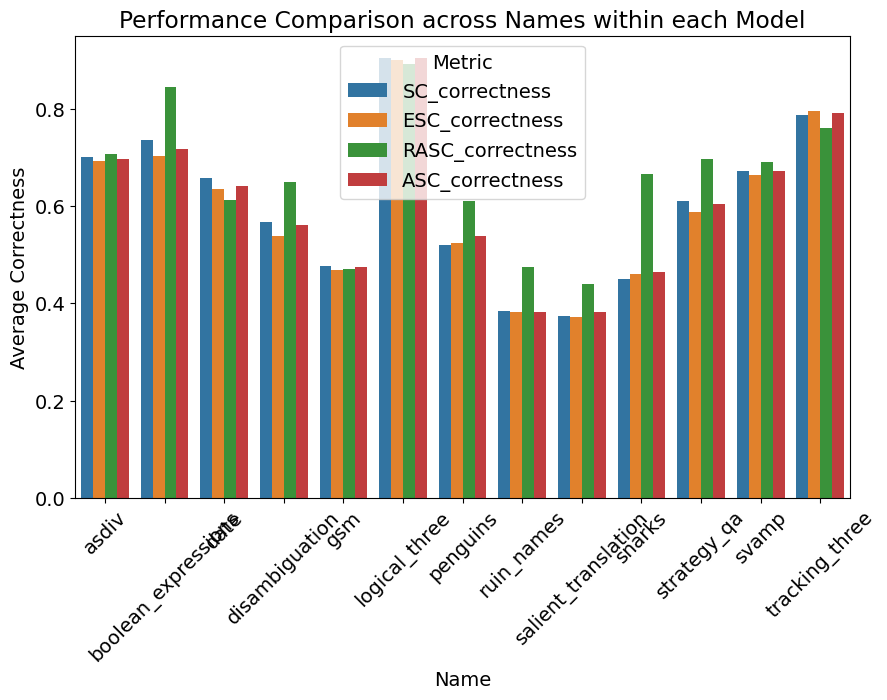

/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_19873/901567787.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Model', y='value', hue='Metric', data=correctness_data, ci=None)


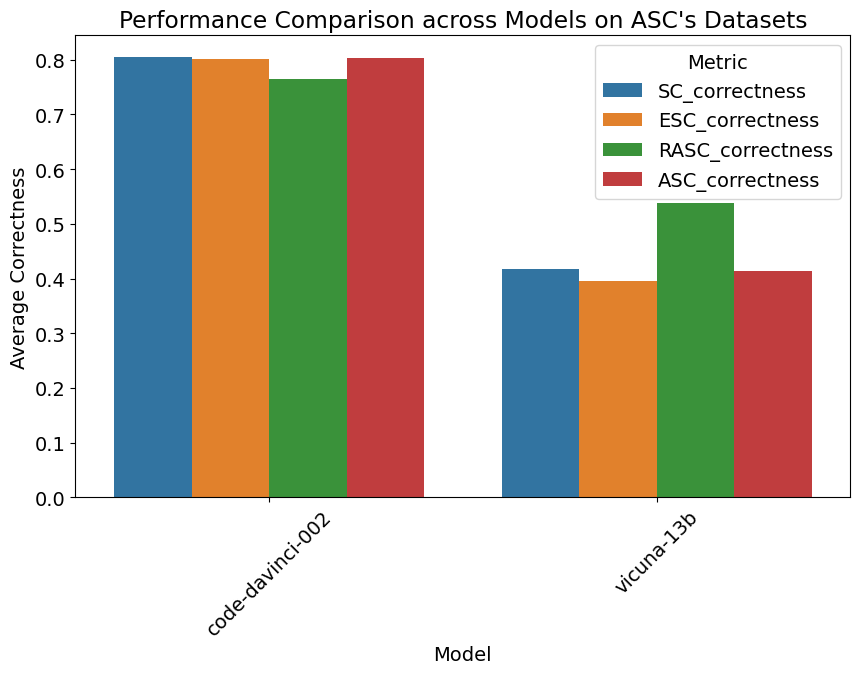

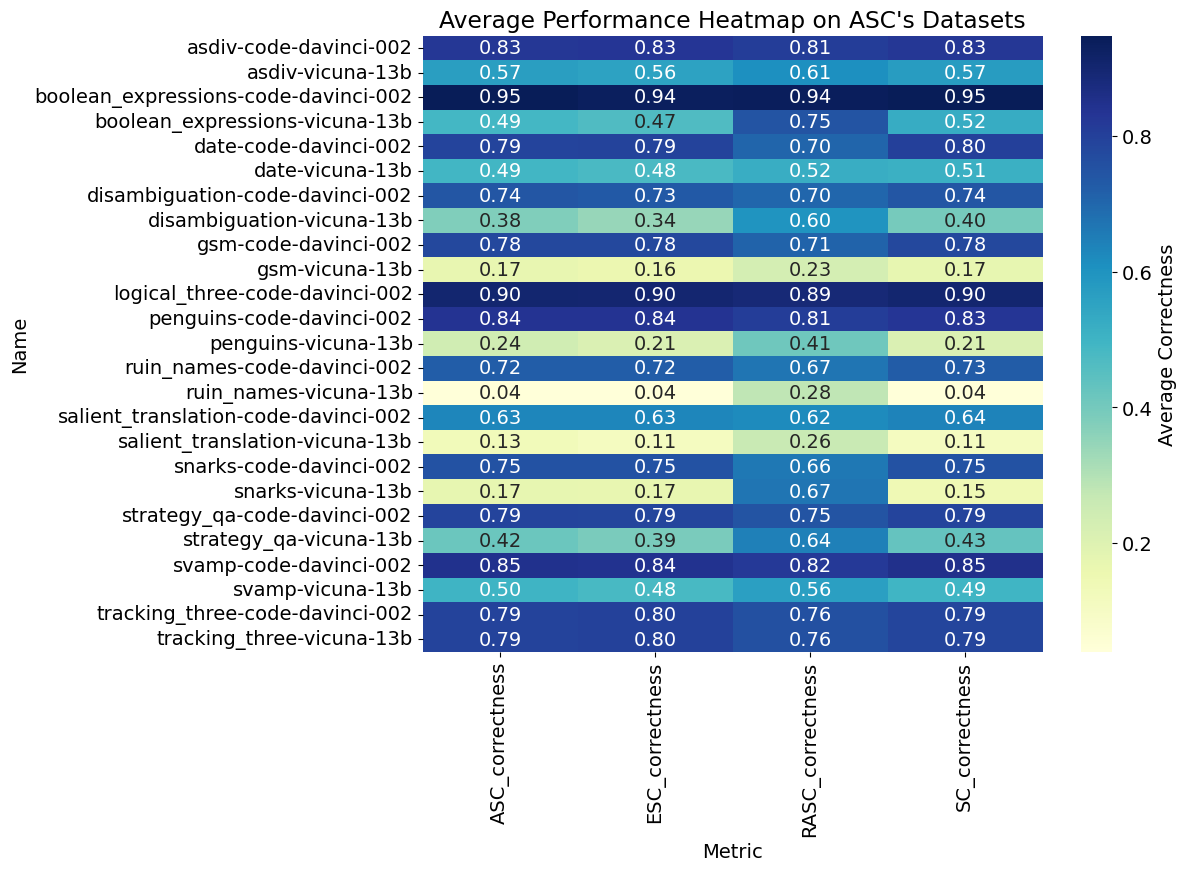

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = df_final_asc

df = df.rename(columns={'ES_steps':'ESC_steps','CS_steps':'RASC_steps','CS_correctness':'RASC_correctness','ES_correctness':'ESC_correctness',"asc_steps":"ASC_steps","asc_correctness":"ASC_correctness"})
# Assuming df is your DataFrame that includes 'asc_correctness' and 'asc_steps'

# Melt the DataFrame to convert it into a long format suitable for plotting
# Include 'asc_correctness' and 'asc_steps' in value_vars
melted_df = pd.melt(df, id_vars=['Name', 'Model'], value_vars=['SC_correctness', 'ESC_correctness', 'RASC_correctness', 'ASC_correctness', 'ASC_steps'], var_name='Metric')

# Plot 1: Compare average performance across different Names within each Model for correctness metrics
plt.figure(figsize=(10, 6))
# Filter melted_df to exclude 'asc_steps' for correctness comparison
correctness_data = melted_df[melted_df['Metric'] != 'ASC_steps']
sns.barplot(x='Name', y='value', hue='Metric', data=correctness_data, ci=None)
plt.title('Performance Comparison across Names within each Model')
plt.xlabel('Name')
plt.ylabel('Average Correctness')
plt.legend(title='Metric')
plt.xticks(rotation=45)
plt.show()

# Plot 2: Compare average performance across different Models within each Name for correctness metrics
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='value', hue='Metric', data=correctness_data, ci=None)
plt.title('Performance Comparison across Models on ASC\'s Datasets')
plt.xlabel('Model')
plt.ylabel('Average Correctness')
plt.legend(title='Metric')
plt.xticks(rotation=45)
plt.show()

# Plot 3: Heatmap to visualize the average performance for each combination of Name and Model for correctness metrics
heatmap_data = correctness_data.groupby(['Name', 'Model', 'Metric'])['value'].mean().unstack(level=-1)
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.2f', cbar_kws={'label': 'Average Correctness'})
plt.title('Average Performance Heatmap on ASC\'s Datasets')
plt.xlabel('Metric')
plt.ylabel('Name')
plt.show()

/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_19873/1339918117.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Name', y='value', hue='Metric', data=melted_df, ci=None)


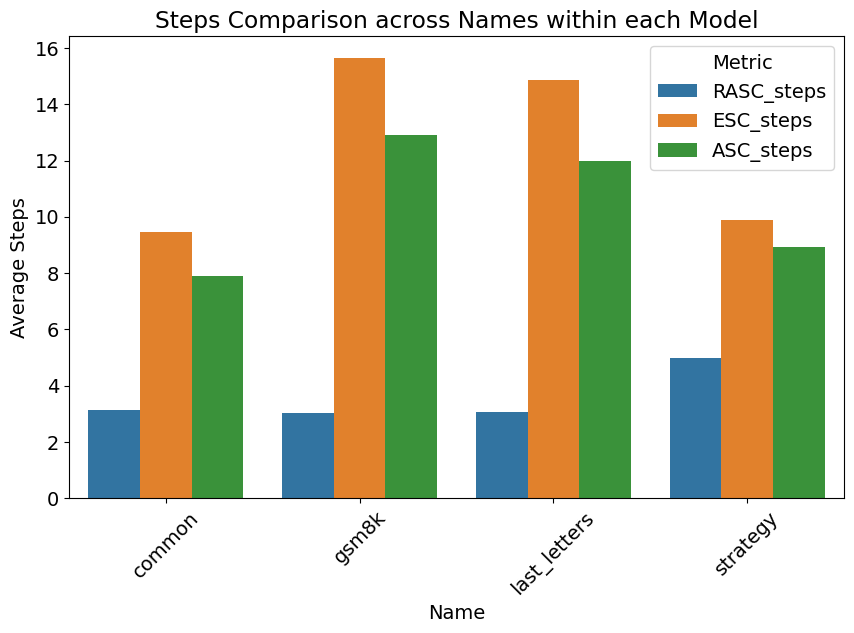

/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_19873/1339918117.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Model', y='value', hue='Metric', data=melted_df, ci=None)


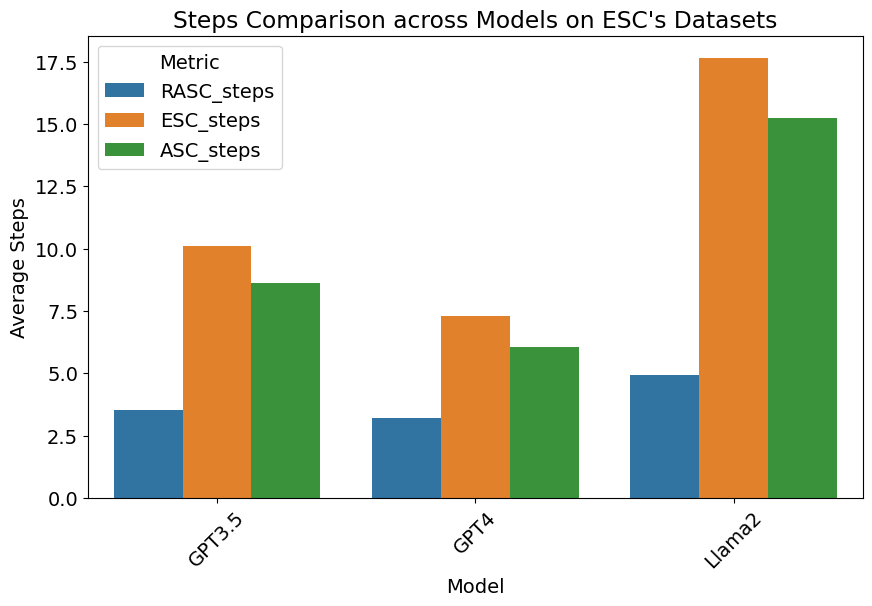

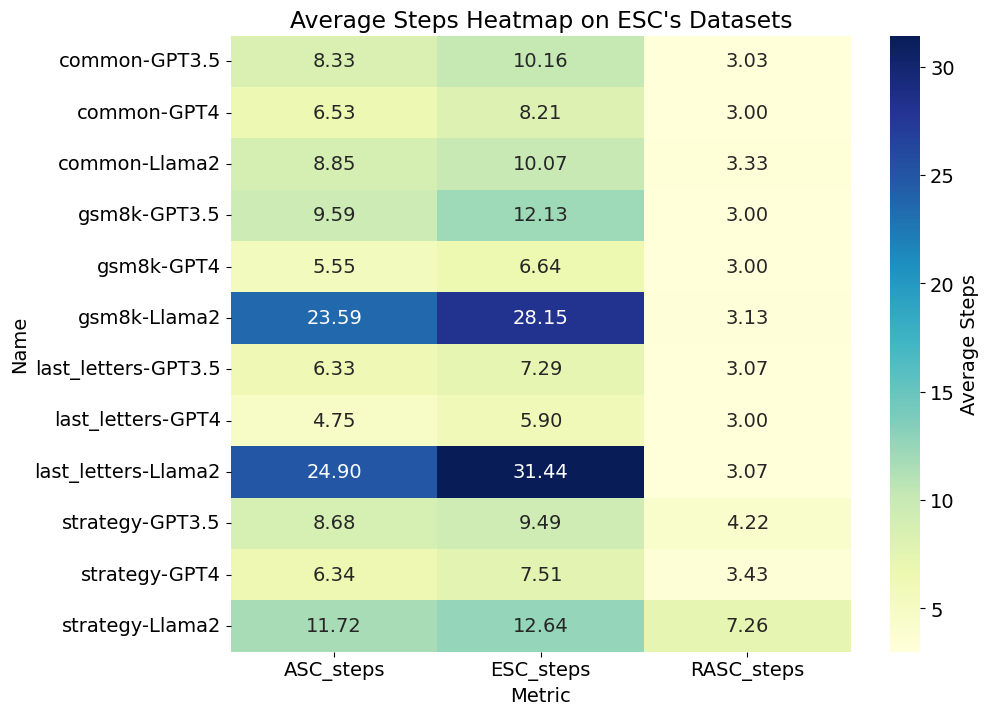

In [43]:
melted_df = pd.melt(df, id_vars=['Name', 'Model'], value_vars=['RASC_steps', 'ESC_steps', 'ASC_steps'], var_name='Metric')

# Plot 1: Compare average steps across different Names within each Model
plt.figure(figsize=(10, 6))
sns.barplot(x='Name', y='value', hue='Metric', data=melted_df, ci=None)
plt.title('Steps Comparison across Names within each Model')
plt.xlabel('Name')
plt.ylabel('Average Steps')
plt.legend(title='Metric')
plt.xticks(rotation=45)
plt.show()

# Plot 2: Compare average steps across different Models within each Name
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='value', hue='Metric', data=melted_df, ci=None)
plt.title('Steps Comparison across Models on ESC\'s Datasets')
plt.xlabel('Model')
plt.ylabel('Average Steps')
plt.legend(title='Metric')
plt.xticks(rotation=45)
plt.show()

# Plot 3: Heatmap to visualize the average steps for each combination of Name and Model
heatmap_data = melted_df.groupby(['Name', 'Model', 'Metric'])['value'].mean().unstack(level=-1)
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.2f', cbar_kws={'label': 'Average Steps'})
plt.title('Average Steps Heatmap on ESC\'s Datasets')
plt.xlabel('Metric')
plt.ylabel('Name')
plt.show()

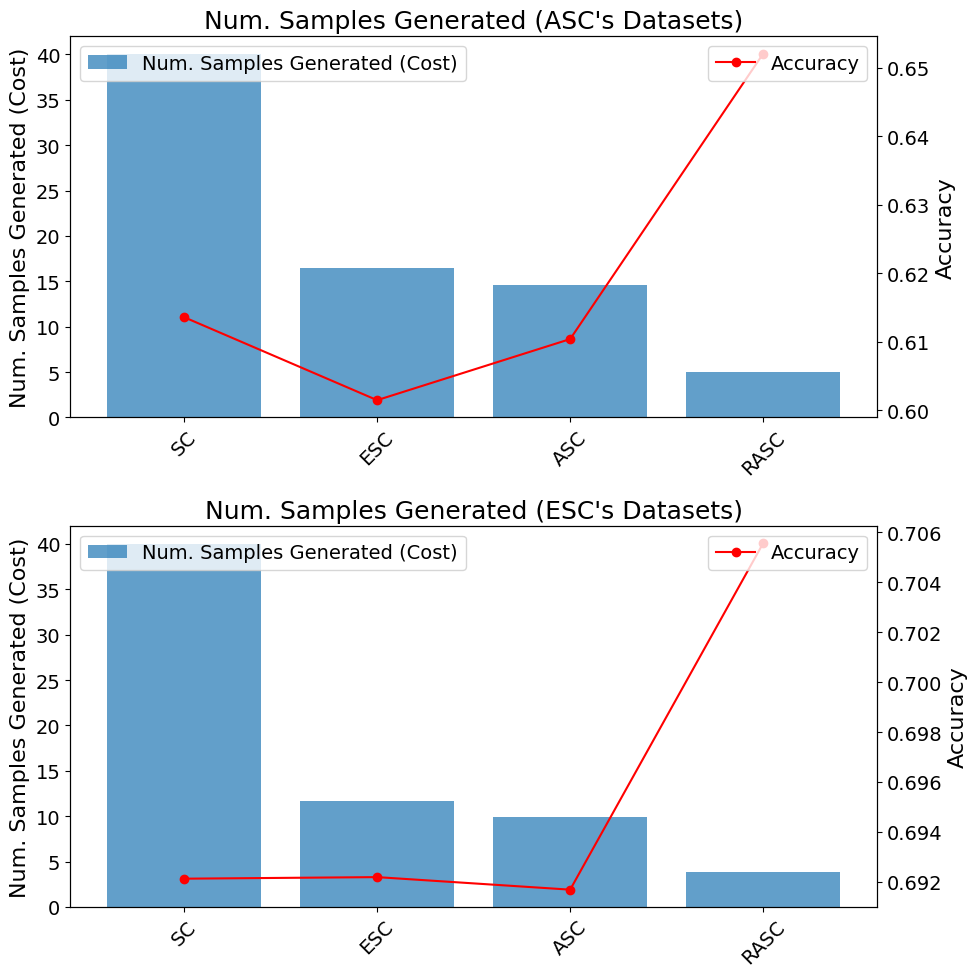

In [34]:
import matplotlib.pyplot as plt
import matplotlib

# Setting global font size
matplotlib.rcParams.update({'font.size': 14})

df_final_ES = df_final_es

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot for df_final_asc
methods_asc = ['SC', 'ESC', 'ASC', 'RASC']
steps_asc = [40, df_final_asc['ES_steps'].mean(), df_final_asc['asc_steps'].mean(), df_final_asc['CS_steps'].mean()]
accuracies_asc = [df_final_asc['SC_correctness'].mean(), df_final_asc['ES_correctness'].mean(),
                   df_final_asc['asc_correctness'].mean(), df_final_asc['CS_correctness'].mean()]

ax1.bar(methods_asc, steps_asc, alpha=0.7, label='Num. Samples Generated (Cost)')
ax1.set_ylabel('Num. Samples Generated (Cost)', fontsize=16)  # Increase font size for y-axis label
ax1.set_title('Num. Samples Generated (ASC\'s Datasets)', fontsize=18)  # Increase font size for title
ax1.tick_params(axis='x', rotation=45, labelsize=14)  # Increase font size for x-axis tick labels

ax1_twin = ax1.twinx()
ax1_twin.plot(methods_asc, accuracies_asc, marker='o', color='red', label='Accuracy')
ax1_twin.set_ylabel('Accuracy', fontsize=16)  # Increase font size for y-axis label

# Plot for df_final_ES
methods_es = ['SC', 'ESC', 'ASC', 'RASC']
steps_es = [40, df_final_ES['ES_steps'].mean(), df_final_ES['asc_steps'].mean(), df_final_ES['CS_steps'].mean()]
accuracies_es = [df_final_ES['SC_correctness'].mean(), df_final_ES['ES_correctness'].mean(),
                 df_final_ES['asc_correctness'].mean(), df_final_ES['CS_correctness'].mean()]

ax2.bar(methods_es, steps_es, alpha=0.7, label='Num. Samples Generated (Cost)')
ax2.set_ylabel('Num. Samples Generated (Cost)', fontsize=16)  # Increase font size for y-axis label
ax2.set_title('Num. Samples Generated (ESC\'s Datasets)', fontsize=18)  # Increase font size for title
ax2.tick_params(axis='x', rotation=45, labelsize=14)  # Increase font size for x-axis tick labels

ax2_twin = ax2.twinx()
ax2_twin.plot(methods_es, accuracies_es, marker='o', color='red', label='Accuracy')
ax2_twin.set_ylabel('Accuracy', fontsize=16)  # Increase font size for y-axis label

# Add legend with increased font size
ax1.legend(loc='upper left', fontsize=14)
ax1_twin.legend(loc='upper right', fontsize=14)
ax2.legend(loc='upper left', fontsize=14)
ax2_twin.legend(loc='upper right', fontsize=14)

plt.tight_layout()
plt.savefig("OOD.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Show plot
plt.show()


# Adjust layout and display the plot



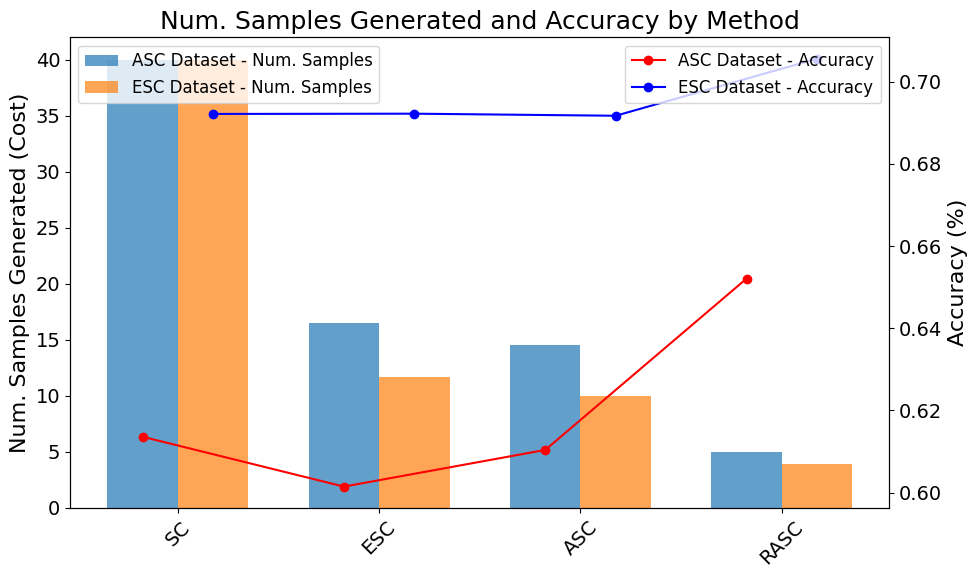

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Setting global font size
plt.rcParams.update({'font.size': 14})

df_final_ES = df_final_es

# Methods and data
methods = ['SC', 'ESC', 'ASC', 'RASC']
steps_asc = [40, df_final_asc['ES_steps'].mean(), df_final_asc['asc_steps'].mean(), df_final_asc['CS_steps'].mean()]
accuracies_asc = [df_final_asc['SC_correctness'].mean(), df_final_asc['ES_correctness'].mean(),
                  df_final_asc['asc_correctness'].mean(), df_final_asc['CS_correctness'].mean()]
steps_es = [40, df_final_ES['ES_steps'].mean(), df_final_ES['asc_steps'].mean(), df_final_ES['CS_steps'].mean()]
accuracies_es = [df_final_ES['SC_correctness'].mean(), df_final_ES['ES_correctness'].mean(),
                 df_final_ES['asc_correctness'].mean(), df_final_ES['CS_correctness'].mean()]

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Set the positions of the bars
x = np.arange(len(methods))  # the label locations
width = 0.35  # the width of the bars

# Plot data
rects1 = ax.bar(x - width/2, steps_asc, width, label='ASC Dataset - Num. Samples', alpha=0.7)
rects2 = ax.bar(x + width/2, steps_es, width, label='ESC Dataset - Num. Samples', alpha=0.7)

# Add lines for accuracy
ax_twin = ax.twinx()
ax_twin.plot(x - width/2, accuracies_asc, marker='o', linestyle='-', color='red', label='ASC Dataset - Accuracy')
ax_twin.plot(x + width/2, accuracies_es, marker='o', linestyle='-', color='blue', label='ESC Dataset - Accuracy')

# Add labels, legend, and title
ax.set_ylabel('Num. Samples Generated (Cost)', fontsize=16)
ax.set_title('Num. Samples Generated and Accuracy by Method', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.tick_params(axis='x', rotation=45, labelsize=14)
ax_twin.set_ylabel('Accuracy (%)', fontsize=16)

# Legend
ax.legend(loc='upper left', fontsize=12)
ax_twin.legend(loc='upper right', fontsize=12)

# Show plot
plt.tight_layout()
plt.show()


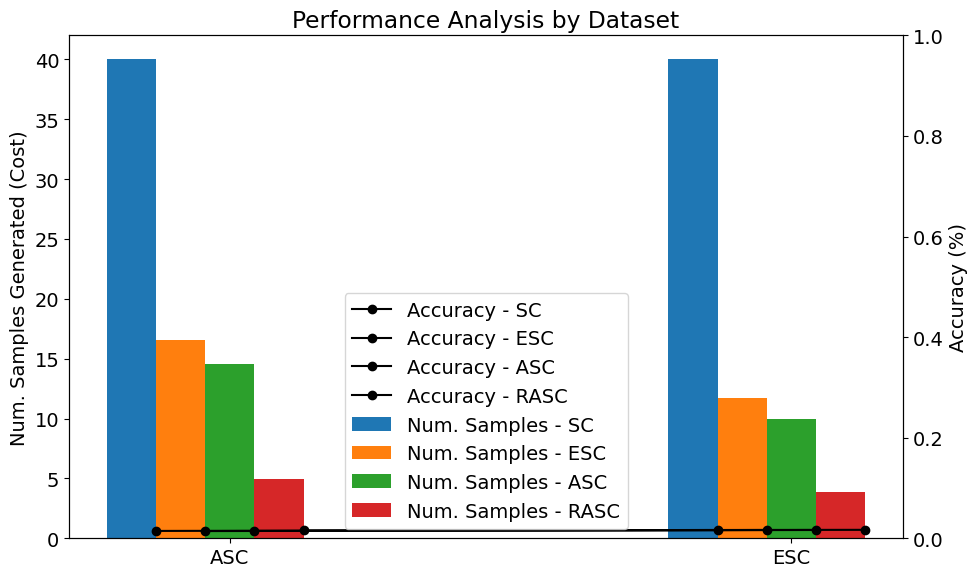

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Setting global font size
plt.rcParams.update({'font.size': 14})
df_final_ES = df_final_es

# Methods and data
datasets = ['ASC', 'ESC']
methods = ['SC', 'ESC', 'ASC', 'RASC']
steps_asc = [40, df_final_asc['ES_steps'].mean(), df_final_asc['asc_steps'].mean(), df_final_asc['CS_steps'].mean()]
accuracies_asc = [df_final_asc['SC_correctness'].mean(), df_final_asc['ES_correctness'].mean(),
                  df_final_asc['asc_correctness'].mean(), df_final_asc['CS_correctness'].mean()]
steps_es = [40, df_final_ES['ES_steps'].mean(), df_final_ES['asc_steps'].mean(), df_final_ES['CS_steps'].mean()]
accuracies_es = [df_final_ES['SC_correctness'].mean(), df_final_ES['ES_correctness'].mean(),
                 df_final_ES['asc_correctness'].mean(), df_final_ES['CS_correctness'].mean()]

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Bar width
width = 0.35  # Adjust the width to create space between bars
x = np.arange(len(datasets))  # x locations for the datasets

# Plotting
for i in range(len(methods)):
    bar_pos = x + i*width/len(methods) - width/2
    ax.bar(bar_pos, [steps_asc[i], steps_es[i]], width/len(methods), label=f'Num. Samples - {methods[i]}')
    
    # Plot accuracy lines within each bar
    line_pos = bar_pos + width/(2*len(methods))
    ax.plot(line_pos, [accuracies_asc[i], accuracies_es[i]], 'o-', color='black', label=f'Accuracy - {methods[i]}')

# Add labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Num. Samples Generated (Cost)')
ax.set_title('Performance Analysis by Dataset')
ax.set_xticks(x)
ax.set_xticklabels(datasets)  # Set x-axis labels to indicate the dataset
ax.legend()

# Create a twin y-axis to plot the accuracy
ax2 = ax.twinx()
ax2.set_ylabel('Accuracy (%)')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()